In [43]:
# importing relevant libraries
import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
import pandas as pd
import numpy as np
import sqlalchemy as sa
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import scale
import pandas as pd
from sklearn import datasets, linear_model, cross_validation, grid_search
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import os
import functools


# Turn off pandas chained assignment warning
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999


# ### 1. CLEAN PLI, PITT & TAX DATA

# # create directory paths for opening files
# curr_path = ''
curr_path = os.path.dirname(os.path.realpath("fs_grid.ipynb"))
dataset_path = os.path.join(curr_path, "datasets/")
inter_path = os.path.join(curr_path,"interResults/")

# read in data
# Reading plidata
plidata = pd.read_csv(os.path.join(dataset_path, "pli.csv"), encoding='utf-8', dtype={'STREET_NUM': 'str', 'STREET_NAME': 'str'}, low_memory=False)
# Reading city of Pittsburgh dataset
pittdata = pd.read_csv(os.path.join(dataset_path, "pittdata.csv"), encoding="ISO-8859-1", dtype={'PROPERTYADDRESS': 'str', 'PROPERTYHOUSENUM': 'str', 'CLASSDESC': 'str'}, low_memory=False)
# Reading tax data
taxdata = pd.read_csv("./datasets/tax.csv", encoding='utf-8')
#read parcel data (matches parcels to census tract and block group
parcel = pd.read_csv(os.path.join(dataset_path, "parcels.csv"), encoding='utf-8')
#read ACS data
acs_data = ['acs_income.csv','acs_occupancy.csv','acs_year_built.csv','acs_year_moved.csv']
def clean_acs(df):
    #Use descriptive names in first row
    df.columns = df.loc[0]
    df = df.drop(0)
    df = df.drop(['Id', 'Id2'], axis=1)
    #Extract census block and tract
    df[['BLOCKCE10', 'TRACTCE10']] = df['Geography'].str.extract(
        'Block Group (\d), Census Tract (\d+\.?\d*)')
    df = df.drop(['Geography'], axis=1)
    #Drop first two columns since they only contain totals
    df = df.drop(df.columns[[0,1]], axis=1)
    #Drop margin of errors
    df = df.drop(df.columns[df.columns.str.startswith('Margin')], axis=1)
    #Convert to numbers
    df['BLOCKCE10'] = df['BLOCKCE10'].astype('float')
    df['TRACTCE10'] = df['TRACTCE10'].astype('float')
    #Multiply tract by 100 to be consistent with other data
    df['TRACTCE10'] = df['TRACTCE10'] * 100
    return df
acs_data = map(lambda x: os.path.join(dataset_path, x), acs_data)
acs_data = map(pd.read_csv, acs_data)
acs_data = map(clean_acs, acs_data)
#Merge datasets together
acs_data_combined = functools.reduce(lambda x,y:x.merge(y, how='outer', on=['BLOCKCE10','TRACTCE10']), acs_data)

# cleaning pitt dataset
# removing all properties outside Pittsburgh, Wilkinsburg, and Ingram
pittdata = pittdata[(pittdata.PROPERTYCITY == 'PITTSBURGH')]  # & (pittdata.PROPERTYCITY == 'WILKINSBURG') & (pittdata.PROPERTYCITY == 'INGRAM')]
# include only residential data
pittdata = pittdata[pittdata['CLASSDESC'] == 'RESIDENTIAL']
address_parcels = pittdata[['PARID','PROPERTYADDRESS','PROPERTYHOUSENUM']].drop_duplicates()
pittdata = pittdata[pittdata['PROPERTYHOUSENUM'] != '0']
pittdata = pittdata[pittdata['PROPERTYADDRESS'] != '']
# dropping columns with less than 15% data
pittdata = pittdata.dropna(thresh=4000, axis=1)
pittdata = pittdata.rename(columns={pittdata.columns[0]: 'PARID'})
# pick out necessary columns
pittdata = pittdata[['PARID','PROPERTYHOUSENUM','PROPERTYADDRESS','MUNIDESC','SCHOOLDESC','NEIGHCODE',
                     'TAXDESC','OWNERDESC','USEDESC','LOTAREA','SALEPRICE','FAIRMARKETBUILDING','FAIRMARKETLAND']]
pittdata = pittdata.drop_duplicates()

# cleaning pli dataset
# removing extra whitespaces
plidata['STREET_NAME'] = plidata['STREET_NAME'].str.strip()
plidata['STREET_NUM'] = plidata['STREET_NUM'].str.strip()
# include only residential data
plidata = pd.merge(plidata, address_parcels[['PARID']], how='inner',left_on=['PARCEL'], right_on=['PARID'])
# pick out necessary columns
plidata=plidata[['PARCEL', 'INSPECTION_DATE', 'INSPECTION_RESULT', 'VIOLATION']]
# converting to datetime
plidata.INSPECTION_DATE = pd.to_datetime(plidata.INSPECTION_DATE)
plidata['violation_year'] = plidata['INSPECTION_DATE'].map(lambda x: x.year)
plidata = plidata.drop_duplicates()

# cleaning tax dataset
# removing all properties outside Pittsburgh, Wilkinsburg, and Ingram
taxdata = taxdata[(taxdata.municipality == 'Pittsburgh')]  # & (tax.municipality == 'Wilkinsburg Boro') & (tax.municipality == 'Ingram Boro')]
taxdata = taxdata.dropna(subset=['pin', 'tax_year', 'lien_description', 'amount', 'satisfied'])
# include only residential data
taxdata = pd.merge(taxdata, address_parcels[['PARID']], how='inner', left_on=['pin'], right_on=['PARID'])
# pick out necessary columns
taxdata = taxdata[['pin', 'filing_date', 'tax_year', 'lien_description', 'amount','satisfied']]
taxdata.filing_date = pd.to_datetime(taxdata.filing_date)
taxdata.tax_year=taxdata['tax_year'].apply(lambda x: date(x,12,31))
taxdata.tax_year = pd.to_datetime(taxdata.tax_year)
taxdata = taxdata.drop_duplicates()

# cleaning parcel dataset
# keep only parcel, tract, and block group
parcel = parcel[(parcel.geo_name_cousub == 'Pittsburgh city')]
parcel_blocks = parcel[['PIN', 'TRACTCE10', 'BLOCKCE10']]
#get first digit of block, convert to int
parcel_blocks['BLOCKCE10'] = parcel_blocks['BLOCKCE10'].astype(str).str[0].astype(float)
#ignore bad parcels
parcel_blocks = parcel_blocks[parcel_blocks['PIN'] != ' ']
parcel_blocks = parcel_blocks[parcel_blocks['PIN'] != 'COMMON GROUND']
parcel_blocks = parcel_blocks[~parcel_blocks['PIN'].str.match('.*County')]
parcel_blocks=parcel_blocks.drop_duplicates()


# #### 1.1 Aggregate pittdata to census block, then merge with acs data



pittdata_blocks=pd.merge(pittdata, parcel_blocks, how='left', left_on=['PARID'], right_on=['PIN'])
#drop extra columns
pittdata_blocks = pittdata_blocks.drop(['PARID','PIN','PROPERTYHOUSENUM','PROPERTYADDRESS'], axis=1)


#group by blocks
grouped = pittdata_blocks.groupby(['TRACTCE10','BLOCKCE10'])
#change the '-DESC' columns to the most common in each group (block)
#change the other columns to the mean
max_count = lambda x:x.value_counts().index[0]
pittdata_blocks = grouped.agg({
    'MUNIDESC':max_count,'SCHOOLDESC':max_count,'NEIGHCODE':max_count,
    'TAXDESC':max_count,'OWNERDESC':max_count,'USEDESC':max_count,'LOTAREA':np.mean,
    'SALEPRICE':np.mean,'FAIRMARKETBUILDING':np.mean,'FAIRMARKETLAND':np.mean
})
#reset index to columns
pittdata_blocks = pittdata_blocks.reset_index(level=[0,1])
#merge pittdata with acs
pittacs = pd.merge(pittdata_blocks, acs_data_combined, how='inner', on=['BLOCKCE10','TRACTCE10'])

# keep a copy of blocks and tracts
blocks = pittacs[['TRACTCE10','BLOCKCE10']].drop_duplicates()


# #### 1.2 merge plidata with census block¶

#group by blocks
plidata_blocks = pd.merge(plidata, parcel_blocks, how='left', left_on=['PARCEL'], right_on=['PIN'])
#drop extra columns
plidata_blocks = plidata_blocks.drop(['PARCEL','PIN'], axis=1)
plidata_blocks=plidata_blocks.dropna(subset=['TRACTCE10','BLOCKCE10'])


# #### 1.3 Aggregate taxdata to census block¶

# group by blocks
taxdata_blocks = pd.merge(taxdata,parcel_blocks, how='left', left_on=['pin'], right_on=['PIN'])
taxdata_blocks = taxdata_blocks.drop(['pin','PIN'],axis=1)
taxdata_blocks = taxdata_blocks.dropna(subset=['TRACTCE10','BLOCKCE10'])


# ### 2. Clean fire incident data

# loading fire incidents csvs
fire_pre14 = pd.read_csv(os.path.join(dataset_path, "Fire_Incidents_Pre14.csv"), encoding='latin-1', dtype={'street': 'str', 'number': 'str'}, low_memory=False)
fire_new = pd.read_csv(os.path.join(dataset_path, "Fire_Incidents_New.csv"), encoding='utf-8', dtype={'street': 'str', 'number': 'str'}, low_memory=False)

# cleaning columns of fire_pre14
fire_pre14['full.code'] = fire_pre14['full.code'].str.replace('  -', ' -')
fire_pre14['st_type'] = fire_pre14['st_type'].str.strip()
fire_pre14['street'] = fire_pre14['street'].str.strip()
fire_pre14['number'] = fire_pre14['number'].str.strip()
fire_pre14['st_type'] = fire_pre14['st_type'].str.replace('AV', 'AVE')
fire_pre14['street'] = fire_pre14['street'].str.strip() + ' ' + fire_pre14['st_type'].str.strip()

# drop irrelevant columns
pre14_drop = ['Unnamed: 0','PRIMARY_UNIT', 'MAP_PAGE', 'alm_dttm', 'arv_dttm', 'XCOORD', 
              'YCOORD','inci_id', 'inci_type', 'alarms', 'st_prefix',
              'st_suffix', 'st_type', 'CALL_NO','descript','ï..AGENCY']
for col in pre14_drop:
  del fire_pre14[col]


post14_drop = ['alm_dttm', 'arv_dttm', 'XCOORD', 'YCOORD', 'alarms', 
               'inci_type', 'CALL_NO','descript']
for col in post14_drop:
  del fire_new[col]

# joining both the fire incidents file together
fire_new = fire_new.append(fire_pre14, ignore_index=True)
fire_new = fire_new[fire_new['full.code'].str.strip() != '540 - Animal problem, Other']
fire_new = fire_new[fire_new['full.code'].str.strip() != '5532 - Public Education (Station Visit)']
fire_new = fire_new[fire_new['full.code'].str.strip() != '353 - Removal of victim(s) from stalled elevator']

# correcting problems with the street column
fire_new['street'] = fire_new['street'].replace(to_replace=', PGH', value='', regex=True)
fire_new['street'] = fire_new['street'].replace(to_replace=', P', value='', regex=True)
fire_new['street'] = fire_new['street'].replace(to_replace=',', value='', regex=True)
fire_new['street'] = fire_new['street'].replace(to_replace='#.*', value='', regex=True)
fire_new['street'] = fire_new['street'].str.strip()
fire_new['number'] = fire_new['number'].str.strip()

# converting to date time and extracting year
fireDate, fireTime = fire_new['CALL_CREATED_DATE'].str.split(' ', 1).str
fire_new['CALL_CREATED_DATE'] = fireDate
fire_new['CALL_CREATED_DATE'] = pd.to_datetime(fire_new['CALL_CREATED_DATE'])
fire_new['fire_year'] = fire_new['CALL_CREATED_DATE'].map(lambda x: x.year)

# removing all codes with less than 20 occurences
for col, val in fire_new['full.code'].value_counts().iteritems():
    if val < 20 and col[0] != '1':
        fire_new = fire_new[fire_new['full.code'] != col]

#Split street column when there are 2 streets
street_split = fire_new['street'].str.split('/')
fire_new['street'] = street_split.map(lambda x:x[0])
fire_new = fire_new.dropna(subset=['CALL_CREATED_DATE'])
fire_new = fire_new.drop_duplicates()


# #### 2.1 merge fire incident to census block

# convert from addresses to parcels
fire_parcel = pd.merge(fire_new, address_parcels, how='inner',
                        left_on=['street','number'], right_on=['PROPERTYADDRESS','PROPERTYHOUSENUM'])
# convert from parcels to census blocks
fire_blocks = pd.merge(fire_parcel, parcel_blocks, how='left',left_on=['PARID'], right_on=['PIN'])
#drop extra columns
fire_blocks=fire_blocks.drop(['number','street','PARID','PROPERTYADDRESS',
                              'PROPERTYHOUSENUM','PIN', 'Unnamed: 0',
                              'st_prefix', 'st_suffix', 'st_type',
                              'prop_use_code','response_time',
                              'CALL_TYPE_FINAL', 'COUNCIL', 'NEIGHBORHOOD',
                              'PRIMARY_UNIT','fire_year','prop_use_descript'],axis=1)
#drop data without block or tract (this drops non-residential data)
fire_blocks = fire_blocks.dropna(subset=['TRACTCE10','BLOCKCE10'])
# dropping columns with less than 15% data
fire_blocks = fire_blocks.dropna(thresh=len(fire_blocks)*0.15, axis=1)
fire_blocks = fire_blocks.drop_duplicates()


# ### 3 Join four datasets together

# #### 3.1 joining dynamic data with fire incidents

# making the fire column with all type 100s as fires and map it to 0 or 1
fire_blocks['fire'] = fire_blocks['full.code'].astype(str).                    map(lambda x: 1 if x[0]=='1' else 0)
# keep non-fire incidents as features
nonfire_incidents = fire_blocks[fire_blocks['fire'] != 1]
nonfire_incidents = nonfire_incidents[['CALL_CREATED_DATE','full.code','TRACTCE10', 'BLOCKCE10']]
fire_blocks.drop('full.code',axis=1,inplace=True)


# group by every certain period of time
# reason for setting period to year: tax data is based on year
period = 'A'
fire_groups = fire_blocks.groupby(pd.Grouper(key='CALL_CREATED_DATE', freq=period))
nonfire_groups = nonfire_incidents.groupby(pd.Grouper(key='CALL_CREATED_DATE', freq=period))
plidata_groups = plidata_blocks.groupby(pd.Grouper(key='INSPECTION_DATE', freq=period))
taxdata_groups = taxdata_blocks.groupby(pd.Grouper(key='tax_year', freq=period))

# get the date of the earliest fire in each block in each year
block_fire_dates = fire_groups.apply(lambda x:x.groupby(['TRACTCE10','BLOCKCE10']).apply(lambda x:x[x['fire']==1].min()))

# then group fire by census blocks
def groupByBlock(df,categoricals, method):
    dummies=[pd.get_dummies(df[feature]) for feature in categoricals]
    df = pd.concat([df]+dummies,axis=1)
    df.drop(categoricals,axis=1,inplace=True)
    df = pd.merge(df, blocks, how='right',on=['TRACTCE10','BLOCKCE10'])
    df_grouped=df.groupby(['TRACTCE10','BLOCKCE10'])
    if method == 'max':
        df_grouped=df_grouped.max()
    if method == 'sum':
        df_grouped=df_grouped.sum()
    return df_grouped
fire_divided = fire_groups.apply(groupByBlock,categoricals=[],method='max')
fire_divided.drop('CALL_CREATED_DATE',axis=1,inplace=True)
fire_divided=fire_divided.reset_index()
fire_divided=fire_divided.fillna(0)


# group nonfire incidents by census blocks
def groupByBlockNonfire(df, categoricals, method):
    # only keep data that occurred before the fire
    year = df['CALL_CREATED_DATE'].iloc[0].year
    df = pd.merge(df, block_fire_dates[block_fire_dates['CALL_CREATED_DATE'].dt.year == year], how='left',
                  on=['TRACTCE10', 'BLOCKCE10'], suffixes=['', '_F'])
    df['CALL_CREATED_DATE_F'] = df['CALL_CREATED_DATE_F'].fillna(pd.to_datetime('12-31-' + str(year)))
    df = df[df['CALL_CREATED_DATE'] <= df['CALL_CREATED_DATE_F']]
    df = df.drop(['CALL_CREATED_DATE_F', 'fire'], axis=1)

    dummies = [pd.get_dummies(df[feature]) for feature in categoricals]
    df = pd.concat([df] + dummies, axis=1)
    df.drop(categoricals, axis=1, inplace=True)
    df = pd.merge(df, blocks, how='right', on=['TRACTCE10', 'BLOCKCE10'])
    df_grouped = df.groupby(['TRACTCE10', 'BLOCKCE10'])
    if method == 'max':
        df_grouped = df_grouped.max()
    if method == 'sum':
        df_grouped = df_grouped.sum()
    return df_grouped

nonfire_divided = nonfire_groups.apply(groupByBlockNonfire,categoricals=['full.code'],method='sum')
nonfire_divided=nonfire_divided.reset_index()
nonfire_divided=nonfire_divided.fillna(0)


# group pli incidents by census blocks
def groupByBlock_pli(df):
    # only keep data that occurred before the fire
    year = df['INSPECTION_DATE'].iloc[0].year
    df = pd.merge(df, block_fire_dates[block_fire_dates['CALL_CREATED_DATE'].dt.year == year], how='left',
                  on=['TRACTCE10', 'BLOCKCE10'])
    df['CALL_CREATED_DATE'] = df['CALL_CREATED_DATE'].fillna(pd.to_datetime('12-31-' + str(year)))
    df = df[df['INSPECTION_DATE'] <= df['CALL_CREATED_DATE']]
    df = df.drop(['CALL_CREATED_DATE', 'fire'], axis=1)
    
    INSPECTION_RESULT_dummies=pd.get_dummies(df['INSPECTION_RESULT'])
    VIOLATION_dummies=df['VIOLATION'].str.get_dummies(sep=' :: ')
    df = pd.concat([df,INSPECTION_RESULT_dummies,VIOLATION_dummies],axis=1)
    df.drop(['INSPECTION_RESULT','VIOLATION','violation_year'],axis=1,inplace=True)
    df = pd.merge(df, blocks, how='right',on=['TRACTCE10','BLOCKCE10'])
    df_grouped=df.groupby(['TRACTCE10','BLOCKCE10']).sum()
    return df_grouped
pli_divided=plidata_groups.apply(groupByBlock_pli)
pli_divided=pli_divided.reset_index()
pli_divided=pli_divided.fillna(0)


# group tax data by census blocks
def groupByBlock_tax(df):
    tax_dummies=pd.get_dummies(df['lien_description'])
    df = pd.concat([df,tax_dummies],axis=1)
    df.drop(['lien_description'],axis=1,inplace=True)
    df = pd.merge(df, blocks, how='right',on=['TRACTCE10','BLOCKCE10'])
    df_grouped=df.groupby(['TRACTCE10','BLOCKCE10']).sum()
    return df_grouped

tax_divided=taxdata_groups.apply(groupByBlock,categoricals=['lien_description'],method='sum')
tax_divided=tax_divided.reset_index()
tax_divided=tax_divided.fillna(0)


# join fire, nonfire, pli, tax data together
fire_nonfire = pd.merge(fire_divided,nonfire_divided,how='outer',
                        on=['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'])
fire_nonfire_pli = pd.merge(fire_nonfire,pli_divided,how='outer',
                           left_on=['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],
                           right_on=['INSPECTION_DATE','TRACTCE10','BLOCKCE10'])
fire_nonfire_pli_tax = pd.merge(fire_nonfire_pli,tax_divided,how='outer',
                               left_on=['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],
                               right_on=['tax_year','TRACTCE10','BLOCKCE10'])
fire_nonfire_pli_tax['CALL_CREATED_DATE']=fire_nonfire_pli_tax['CALL_CREATED_DATE'].                                           fillna(fire_nonfire_pli_tax['CALL_CREATED_DATE'])
fire_nonfire_pli_tax.drop(['INSPECTION_DATE','tax_year'],axis=1,inplace=True)


# drop columns with less than thresold% data
threshold=0.0001
s=fire_nonfire_pli_tax.sum()
drop_columns=s[s<len(fire_nonfire_pli_tax)*threshold].index
fire_nonfire_pli_tax.drop(drop_columns,axis=1,inplace=True)


# join with pitt_blocks
combined = pd.merge(fire_nonfire_pli_tax,pittacs,
                    how='left',on=['TRACTCE10','BLOCKCE10'])
features = ['SCHOOLDESC', 'OWNERDESC', 'MUNIDESC', 'NEIGHCODE','TAXDESC', 'USEDESC']
dummies= [pd.get_dummies(combined[feature]) for feature in features]
encoded_combined=pd.concat([combined]+dummies,axis=1)
encoded_combined.drop(features,axis=1,inplace=True)
encoded_combined=encoded_combined.dropna(subset=['CALL_CREATED_DATE'])
encoded_combined = encoded_combined.drop_duplicates()
encoded_combined=encoded_combined.fillna(0)
encoded_combined = encoded_combined[encoded_combined.CALL_CREATED_DATE <= '2017-12-31']

# ### 4 Split data into training set and test set
# PREPARING THE TESTING DATA (final 1 year of data)
cutoffdate = '2016-12-31'
# preparing training set
encoded_traindata = encoded_combined[encoded_combined.CALL_CREATED_DATE <= cutoffdate]

#making valuation dataset before CALL_CREATED_DATE is deleted
val_cutoffdate = '2015-12-31'

encoded_traindata.to_csv("encode_train.csv")
valuation_data = encoded_traindata[encoded_traindata.CALL_CREATED_DATE > val_cutoffdate]
fs_train_data = encoded_traindata[encoded_traindata.CALL_CREATED_DATE <= val_cutoffdate]

valuation_data = valuation_data.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'], axis=1)
fs_train_data = fs_train_data.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'], axis=1)

encoded_traindata.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],axis=1,inplace=True)
encoded_traindata.fillna(0)
X_train=np.array(encoded_traindata.drop(['fire'],axis=1))
y_train=np.array(encoded_traindata['fire'])

# preparing test set
encoded_testdata = encoded_combined[encoded_combined.CALL_CREATED_DATE > cutoffdate]
encoded_testdata.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],axis=1,inplace=True)
encoded_testdata.fillna(0)
X_test=np.array(encoded_testdata.drop(['fire'],axis=1))
y_test=np.array(encoded_testdata['fire'])

#converting to array and reshaping the data to prep for model
fireVarTrain = encoded_traindata['fire']
#del encoded_traindata['fire']
no_fire_train = encoded_traindata.drop(['fire'], axis =1)
X_train = np.array(no_fire_train)
y_train = np.reshape(fireVarTrain.values,[fireVarTrain.shape[0],])

#converting to array and reshaping the data to prep for model
fireVarTest = encoded_testdata['fire']
#del encoded_testdata['fire']
no_fire_test = encoded_testdata.drop(['fire'], axis =1)
#dropping fire attribute to make fire valuation dataset later
X_test = np.array(no_fire_test)
y_test = np.reshape(fireVarTest.values,[fireVarTest.shape[0],])

X_validation = np.array(fs_train_data.drop(['fire'], axis=1))
y_validation = np.array(fs_train_data['fire'])

# Random Forest model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 65)
model.fit(X_train, y_train)
pred_rf = model.predict(X_test)
real = y_test
cm_rf = confusion_matrix(real, pred_rf)
print(cm_rf)

kappa_rf = cohen_kappa_score(real, pred_rf)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_rf, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

acc_rf = 'Accuracy = {0} \n \n'.format(float(cm_rf[0][0] + cm_rf[1][1]) / len(real))
kapp_rf = 'kappa score = {0} \n \n'.format(kappa_rf)
auc_rf = 'AUC Score = {0} \n \n'.format(metrics.auc(fpr, tpr))
recall_rf = 'recall = {0} \n \n'.format(tpr[1])
precis_rf = 'precision = {0} \n \n'.format(float(cm_rf[1][1]) / (cm_rf[1][1] + cm_rf[0][1]))

print(acc_rf)
print(kapp_rf)
print(auc_rf)
print(recall_rf)
print(precis_rf)

print("Start Feature Selection")
# ==== Feature Selection using Feature Importance =====
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score


# calculate imputed test dataset
imputed_fireVarTest = fireVarTest.fillna(method="ffill")
impute_X_test = np.array(encoded_testdata.drop('fire',axis=1).fillna(method="ffill"))
impute_y_test = np.reshape(imputed_fireVarTest.values, [imputed_fireVarTest.shape[0],])

#model for feature selection
selection_model = RandomForestClassifier(n_estimators = 60, max_depth=3, random_state=27)

# create the list of features with corresponding feature importances
feature_importance = pd.Series(data=model.feature_importances_, index=encoded_traindata.drop(['fire'], axis =1).columns)


#sort the feature importance from low to hi
feature_importance = feature_importance.sort_values()
# Making threshold smaller
thresh_num = X_validation.shape[1]

feature_result = pd.DataFrame(columns=('Last_Feature', 'Thresh', 'Acc', 'Kapp', 'AUC', 'Recall', 'Precis'))
low_thresh = feature_importance[0]
print(feature_importance[0])

E:\Program Files\Anaconda3\envs\crookshanks\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
E:\Program Files\Anaconda3\envs\crookshanks\lib\site-packages\ipykernel\__main__.py:66: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


[[132  11]
 [ 92 108]]
Accuracy = 0.6997084548104956 
 

kappa score = 0.4284905446721776 
 

AUC Score = 0.7315384615384616 
 

recall = 0.54 
 

precision = 0.907563025210084 
 

Start Feature Selection
0.0


In [72]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(n_estimators = 100, random_state=27, algorithm='SAMME.R')
model_adaboost.fit(X_train, y_train)
#pred_adaboost = model_adaboost.predict(X_validation)
pred_adaboost = model_adaboost.predict(X_test)
#real_adaboost = y_validation
real_adaboost = y_test
cm_ada = confusion_matrix(real_adaboost, pred_adaboost)
print(cm_ada)

kappa_ada = cohen_kappa_score(real_adaboost, pred_adaboost)

#compute ROC curve and area under the curve
# fpr, tpr, thresholds = metrics.roc_curve(y_validation, pred_adaboost, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_adaboost, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

acc_ada = 'Accuracy = {0} \n \n'.format(float(cm_ada[0][0] + cm_ada[1][1]) / len(real_adaboost))
kapp_ada = 'kappa score = {0} \n \n'.format(kappa_ada)
auc_ada = 'AUC Score = {0} \n \n'.format(metrics.auc(fpr, tpr))
recall_ada = 'recall = {0} \n \n'.format(tpr[1])
precis_ada = 'precision = {0} \n \n'.format(float(cm_ada[1][1]) / (cm_ada[1][1] + cm_ada[0][1]))

print(acc_ada)
print(kapp_ada)
print(auc_ada)
print(recall_ada)
print(precis_ada)

[[142   1]
 [108  92]]
Accuracy = 0.6822157434402333 
 

kappa score = 0.4093587576423009 
 

AUC Score = 0.7265034965034965 
 

recall = 0.46 
 

precision = 0.989247311827957 
 



In [45]:
# The XG Boost model
model_xgboost = XGBClassifier(learning_rate=0.13, n_estimators=1500,
                              objective='binary:logistic',nthread=4,seed=27)
model_xgboost.fit(X_train, y_train)
# pred_xgboost = model_xgboost.predict(X_validation)
pred_xgboost = model_xgboost.predict(X_test)
# real_xgboost = y_validation
real_xgboost = y_test
cm_xg = confusion_matrix(real_xgboost, pred_xgboost)
print(cm_xg)

from sklearn.metrics import cohen_kappa_score
kappa_xg = cohen_kappa_score(real_xgboost, pred_xgboost)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_xgboost, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

acc_xg = 'Accuracy = {0} \n \n'.format(float(cm_xg[0][0] + cm_xg[1][1]) / len(real_xgboost))
kapp_xg = 'kappa score = {0} \n \n'.format(kappa_xg)
auc_xg = 'AUC Score = {0} \n \n'.format(metrics.auc(fpr, tpr))
recall_xg = 'recall = {0} \n \n'.format(tpr[1])
precis_xg = 'precision = {0} \n \n'.format(float(cm_xg[1][1]) / (cm_xg[1][1] + cm_xg[0][1]))

print(acc_xg)
print(kapp_xg)
print(auc_xg)
print(recall_xg)
print(precis_xg)

[[140   3]
 [102  98]]
Accuracy = 0.6938775510204082 
 

kappa score = 0.4269051445666183 
 

AUC Score = 0.7345104895104895 
 

recall = 0.49 
 

precision = 0.9702970297029703 
 



In [46]:
#model for feature selection
selection_model = RandomForestClassifier(n_estimators = 60, max_depth=3, random_state=27)

# create the list of features with corresponding feature importances
feature_importance = pd.Series(data=model.feature_importances_, index=encoded_traindata.drop(['fire'], axis =1).columns)


#sort the feature importance from low to hi
feature_importance = feature_importance.sort_values()
# Making threshold smaller
thresh_num = X_validation.shape[1]

feature_result = pd.DataFrame(columns=('Last_Feature', 'Thresh', 'Acc', 'Kapp', 'AUC', 'Recall', 'Precis'))
low_thresh = feature_importance[0]
print(feature_importance[0])
for i in range(feature_importance.size-thresh_num, feature_importance.size-2):
    # select features using threshold
    if feature_importance[i] == low_thresh:
        continue
    else:
        low_thresh = feature_importance[i]
#         print(feature_importance[i])
    selection = SelectFromModel(model, threshold=feature_importance[i], prefit=True)
    select_X_train = selection.transform(X_train)

    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_validation)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    #metric calculation
    fpr, tpr, thresholds = metrics.roc_curve(y_validation, predictions, pos_label=1)
    accuracy = accuracy_score(y_validation, predictions)
    cm = confusion_matrix(y_validation, predictions)
#     print(confusion_matrix(y_validation, predictions))

    kappa = cohen_kappa_score(y_validation, predictions)
    acc = float(cm[0][0] + cm[1][1]) / len(y_validation)
    auc = metrics.auc(fpr, tpr)
    recall = tpr[1]
    precis = float(cm[1][1]) / (cm[1][1] + cm[0][1])

#     print("Thresh=%.3f, n=%d" % (feature_importance[i], select_X_train.shape[1]))
#     print('Accuracy = {0} \n \n'.format(acc))
#     print('kappa score = {0} \n \n'.format(kappa))
#     print('AUC Score = {0} \n \n'.format(auc))
#     print('recall = {0} \n \n'.format(recall))
#     print('precision = {0} \n \n'.format(precis))

    feature_result.loc[i] = [feature_importance.index[i], feature_importance[i], acc, kappa, auc, recall, precis]

#find the best f1
feature_result['F1'] = 2* (feature_result['Recall']*feature_result['Precis']) / (feature_result['Recall']+feature_result['Precis'])
max_f1 = feature_result['F1'].idxmax()
best_row = feature_result.loc[feature_result['F1'].idxmax()]
print("best row:")
print(best_row)


0.0
best row:
Last_Feature    SALEPRICE
Thresh          0.0177974
Acc              0.733722
Kapp             0.456522
AUC              0.724713
Recall           0.857143
Precis           0.706677
F1               0.774671
Name: 432, dtype: object


In [47]:
feature_result.to_csv("Feature_Selection_Results{0}.csv".format(datetime.datetime.now().strftime('%m%d-%H%M%S')), 'a')

## grid search

In [71]:
# grid search on adaboost
tuned_parameters={'algorithm': ['SAMME','SAMME.R'],'n_estimators':[1,10,100,1000,10000]}
print ("## Tuning for %s"%'adaboost')
score='f1'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(model_adaboost, tuned_parameters, cv=tscv,scoring= score)
print('Model setted up')
clf.fit(select_X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(select_X_test)
print(classification_report(y_true, y_pred))
print()

## Tuning for adaboost
# Tuning hyper-parameters for f1

Model setted up
Best parameters set found on development set:

{'algorithm': 'SAMME.R', 'n_estimators': 100}

Grid scores on development set:

0.663 (+/-0.112) for {'algorithm': 'SAMME', 'n_estimators': 1}
0.682 (+/-0.021) for {'algorithm': 'SAMME', 'n_estimators': 10}
0.684 (+/-0.059) for {'algorithm': 'SAMME', 'n_estimators': 100}
0.721 (+/-0.014) for {'algorithm': 'SAMME', 'n_estimators': 1000}
0.718 (+/-0.021) for {'algorithm': 'SAMME', 'n_estimators': 10000}
0.663 (+/-0.112) for {'algorithm': 'SAMME.R', 'n_estimators': 1}
0.688 (+/-0.068) for {'algorithm': 'SAMME.R', 'n_estimators': 10}
0.725 (+/-0.024) for {'algorithm': 'SAMME.R', 'n_estimators': 100}
0.710 (+/-0.023) for {'algorithm': 'SAMME.R', 'n_estimators': 1000}
0.685 (+/-0.071) for {'algorithm': 'SAMME.R', 'n_estimators': 10000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

   

In [56]:
thres = feature_result.loc[feature_result['F1'] == feature_result['F1'][max_f1]]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit


selection = SelectFromModel(model, threshold=thres.iloc[0]['Thresh'], prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(impute_X_test)

scores=['recall_macro']
tscv =TimeSeriesSplit(n_splits=3) 

tuned_parameters= {'n_estimators':[1,10,50, 60,100,500],
                   'max_depth':[None,3,5,10,20],
                   'max_features':['sqrt','log2']}
print ("## Tuning for %s"%model)
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=tscv,scoring= score)
    print('Model setted up')
    clf.fit(select_X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(select_X_test)
    print(classification_report(y_true, y_pred))
    print()

## Tuning for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
# Tuning hyper-parameters for recall_macro

Model setted up
Best parameters set found on development set:

{'max_features': 'log2', 'max_depth': 10, 'n_estimators': 500}

Grid scores on development set:

0.638 (+/-0.035) for {'max_features': 'sqrt', 'max_depth': 3, 'n_estimators': 1}
0.704 (+/-0.089) for {'max_features': 'sqrt', 'max_depth': 3, 'n_estimators': 10}
0.698 (+/-0.090) for {'max_features': 'sqrt', 'max_depth': 3, 'n_estimators': 50}
0.696 (+/-0.097) for {'max_features': 'sqrt', 'max_depth': 3, 'n_estimators': 60}
0.705 (+/-0.114) for {'max_feature

#### best params
f1_ada: 0.725 (+/-0.024) for {'algorithm': 'SAMME.R', 'n_estimators': 100}
recall_ada: 0.737 (+/-0.019) for {'algorithm': 'SAMME', 'n_estimators': 1000}
recall: 0.738 (+/-0.051) for {'max_features': 'log2', 'max_depth': 10, 'n_estimators': 500}
f1: 0.702 (+/-0.066) for {'max_features': 'sqrt', 'max_depth': 10, 'n_estimators': 60}
auc: 0.815 (+/-0.032) for {'max_features': 'log2', 'max_depth': 5, 'n_estimators': 70}
0.726 (+/-0.051) for {'max_features': 'log2', 'max_depth': 1, 'n_estimators': 1}
0.758 (+/-0.312) for {'max_features': 'log2', 'max_depth': 5, 'n_estimators': 10}
0.770 (+/-0.032) for {'max_features': 'log2', 'max_depth': 5, 'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.93      0.86      0.89       483
        1.0       0.71      0.85      0.77       203

avg / total       0.87      0.85      0.86       686

In [59]:
#test on the test data
tuned_model = RandomForestClassifier(n_estimators = 500, max_depth=10, random_state=27,max_features='log2')
tuned_model.fit(select_X_train, y_train)
y_pred = tuned_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
fpr, tpr, thresholds = metrics.roc_curve(impute_y_test, predictions, pos_label=1)
accuracy = accuracy_score(impute_y_test, predictions)
cm = confusion_matrix(impute_y_test, predictions)
print(confusion_matrix(impute_y_test, predictions))

kappa = cohen_kappa_score(impute_y_test, predictions)
acc = float(cm[0][0] + cm[1][1]) / len(impute_y_test)
auc = metrics.auc(fpr, tpr)
recall = tpr[1]
precis = float(cm[1][1]) / (cm[1][1] + cm[0][1])

print('Final Test Data Results')
print("Thresh=%d, n=%d" % (thres.iloc[0]['Thresh'], select_X_test.shape[1]))
print('Accuracy = {0} \n \n'.format(acc))
print('kappa score = {0} \n \n'.format(kappa))
print('AUC Score = {0} \n \n'.format(auc))
print('recall = {0} \n \n'.format(recall))
print('precision = {0} \n \n'.format(precis))


#Tree model for getting features importance
clf = ExtraTreesClassifier()

clf = clf.fit(X_train, y_train)


UsedDf = encoded_traindata.drop('fire',axis=1)
important_features = pd.Series(data=clf.feature_importances_,index=UsedDf.columns)
important_features.sort_values(ascending=False,inplace=True)
#top 20 features
print(important_features[0:20])

#Plotting the top 20 features
y_pos = np.arange(len(important_features.index[0:20]))

plt.bar(y_pos,important_features.values[0:20], alpha=0.3)
plt.xticks(y_pos, important_features.index[0:20], rotation = (90), fontsize = 11, ha='left')
plt.ylabel('Feature Importance Scores')
plt.title('Feature Importance')


#features_png = "{0}FeatureImportancePlot_{1}.png".format(png_path, datetime.datetime.now())
#plt.savefig(features_png, dpi=150)
#plt.clf()
# Write model performance to log file:
log_path = os.path.join(curr_path, "log/")
important_features[0:50].to_csv('{0}FeatureImportanceList_{1}.csv'.format(log_path, datetime.datetime.now().strftime('%m%d-%H%M%S')), 'a')

[[129  14]
 [ 85 115]]
Final Test Data Results
Thresh=0, n=11
Accuracy = 0.7113702623906706 
 

kappa score = 0.44557284438421474 
 

AUC Score = 0.738548951048951 
 

recall = 0.575 
 

precision = 0.8914728682170543 
 

321 - EMS call, excluding vehicle accident with injury       0.032743
amount                                                       0.025207
Allegheny County Tax Lien                                    0.023544
311 - Medical assist, assist EMS crew                        0.022055
6111 - Dispatched & cancelled on arrival                     0.020990
City & School Tax Lien                                       0.018968
Estimate; Owner occupied:                                    0.018578
600 - Good intent call, Other                                0.016573
FAIRMARKETLAND                                               0.016271
743 - Smoke detector activation, no fire - unintentional     0.014200
611 - Dispatched & cancelled en route                        0.013872
Estimate

In [78]:
proba = tuned_model.predict_proba(select_X_test)
proba

array([[  3.91090332e-01,   6.08909668e-01],
       [  5.17804902e-01,   4.82195098e-01],
       [  5.44945288e-01,   4.55054712e-01],
       [  8.76711646e-01,   1.23288354e-01],
       [  7.08300409e-01,   2.91699591e-01],
       [  9.21371566e-01,   7.86284342e-02],
       [  9.95892265e-01,   4.10773549e-03],
       [  7.93424993e-01,   2.06575007e-01],
       [  8.12579189e-01,   1.87420811e-01],
       [  7.92452174e-01,   2.07547826e-01],
       [  6.31648021e-01,   3.68351979e-01],
       [  2.55141579e-01,   7.44858421e-01],
       [  7.08620006e-01,   2.91379994e-01],
       [  8.88160814e-01,   1.11839186e-01],
       [  8.70350451e-01,   1.29649549e-01],
       [  8.89221258e-01,   1.10778742e-01],
       [  4.55896515e-01,   5.44103485e-01],
       [  6.45873389e-01,   3.54126611e-01],
       [  3.34488606e-01,   6.65511394e-01],
       [  8.05035896e-01,   1.94964104e-01],
       [  6.50404005e-01,   3.49595995e-01],
       [  4.76823874e-01,   5.23176126e-01],
       [  

In [80]:
plt.hist(proba[:,1],bins=[0,0.3, 0.7,1])

(array([ 113.,  207.,   23.]),
 array([ 0. ,  0.3,  0.7,  1. ]),
 <a list of 3 Patch objects>)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=27)


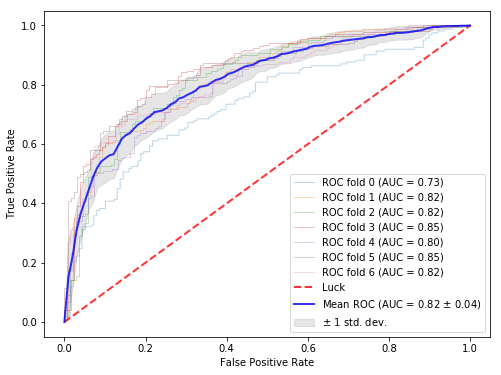

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.13, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1500, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)


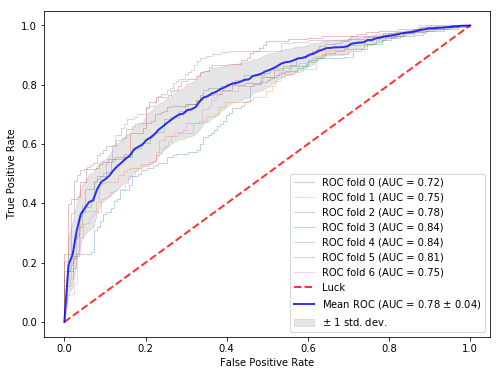

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=27, verbose=0, warm_start=False)


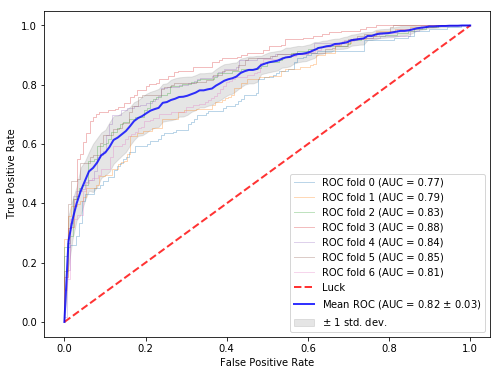

In [82]:
from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import KFold
from scipy import interp
d=0
for model in [model_adaboost,model_xgboost,tuned_model]:
    print(model)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    # 7-fold time series cv because training data contains 8 years of records.
    tscv =TimeSeriesSplit(n_splits=7) 
    # cv = KFold(n_splits=10)
    i = 0
    plt.figure(figsize=(8,6))
    for train, test in tscv.split(select_X_train, y_train):
        probas_ = model.fit(select_X_train[train], y_train[train]).predict_proba(select_X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_train[test], probas_[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('roc_%d.png'%d)
    plt.show()
    d+=1